# Background GRB Events
## Author(s)
    Adam Dressel
    Lindsey Carboneau
## Algorithm


1. In the frame where the GRB occurs, estimate the background level. In practice, I find that sorting the pixel values and taking the median of the faintest 20% of them works pretty well, is easy to code, and is fast. Get the standard deviation of the faintest 20% as well.

2. Generate a random (RA, Dec) position that's within about a degree (say 180 pixels) of the potential GRB position. There are lots of ways to do that, and there IS a formal solution (I think involving a Gibb's process), but it's probably a LOT easier to just use rejection sampling: that is, generate (RA, Dec) pairs for which both RA and Dec are each no more than 180 pixels away on an individual basis, and then just throw out the ones for whi-ch the Euclidean distance is more than 180 pixels.

3. Use TESScut to get an image around the point that you generated. You might have to build some error-checking to ensure that the point really was imaged and doesn't lie off the CCD. Actually you WILL have to build some error checking for the general problem, but if your original possible GRB is less than 180 pixels from the edge of the CCD you can get away without it.

4. Take the N (2, or 4, or whatever your image size was) pixels closest to your generated position within the TESScut frame, and test to see if there's a bright-ish star in there. You can do that by taking the brightest pixel of the 2/4/whatever and testing to see if its value is less than your background value from step 1 plus something like 1-2-3 times the standard deviation of the background from step 1. I'd try 1 standard deviation first because it's conservative, but if things take too long to run you might have to relax that.

5. If your generated position passes the star test, continue. If not, go back to step 2 and repeat.

6. Now test to see if there's a GRB-like event in your 4-pixel image. You can do this by making a movie and looking (which will be time-consuming) or finding some cleverer way. One compromise you might try is to make a light curve from your little image and see if there are any large (>6 sigma?) outliers present.

7. Now go back to step 2 and repeat, until you have 100 successful tests (successful means that you generated a nominally empty image and searched for a flash, NOT that you found a flash!). That should be enough to give a good sense of the background flash rate in nominally empty images near your original one...

    Algorithm by 
        Dr. Derek Buzasi

In [1]:
import numpy as np
from astropy.io import fits
from zipfile import ZipFile
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation
from IPython.display import HTML
import random
import math
import requests
import re
import shutil

## Code for opening FITS FILES
The following code is re-used from previous python scripts to read FITS files.
This code also appends data to arrays to be used for manipulation and visualization.

s0004-2-2
1060


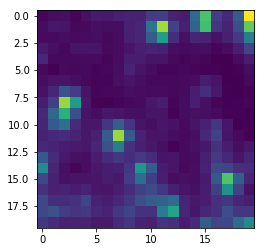

In [2]:
#function for opening fits file and getting header and pixel data
def read_fits_file(target_file):
    tess_file = fits.open(target_file)
    header_data = tess_file[1].header
    check_data = tess_file[1].data
    tess_file.close()
    # Converts flux values to an array.
    pixel_data = np.asarray(check_data)
    return (header_data, pixel_data, check_data)

input_file ='./Candidate_GRBs/astrocut_56.795_-29.332_20x20px/tess-s0004-2-2_56.795000_-29.332000_20x20_astrocut.fits'
# step 1: read in the data

header, pixels, check = read_fits_file(input_file)

# Sector, camera and ccd value for fits file
sec_data = re.findall('s\d\d\d\d-\d-\d',input_file)[0]
print(sec_data)

#THe flux values of the GRB frame
GRB_frame = np.stack(pixels['FLUX'][512])
GRB_post_flash = np.stack(pixels['FLUX'][513])
GRB_pre_flash = np.stack(pixels['FLUX'][161])
plt.imshow(GRB_post_flash)
print(len(pixels['FLUX']))

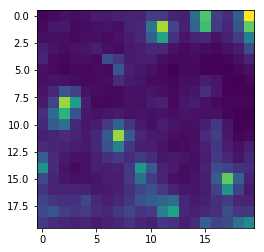

In [3]:
plt.imshow(GRB_frame)

## 1. Estimating Background Level
    In the previous cell we found the frame where the possible GRB occurs in this file.
    Since this particular file is a 20x20, we sort the 400 pixels and then take the lowest 20%, or first 80 values. We then find the median for these values

In [4]:
# Reshape flux values for pixels at GRB frame
GRB_frame_list = GRB_frame.reshape(400)
GRB_frame_list.sort()

# Get the faintest 20% of pixels
faint_pix = GRB_frame_list[0:80]

bkgnd_median = np.median(faint_pix)
bkgnd_std = np.std(faint_pix)
print(bkgnd_median + bkgnd_std)
print(bkgnd_std)

83.507286
0.43479005


## 2. Generating Random RA and Dec
    After finding the median and standard deviation, we then generate random Right Ascension and Declination coordinates. We test these values by ensuring the Euclidiean distance between the original and random coordinate is less than 1.


In [58]:
#RA and Dec of current target
RA = 56.795
Dec = -29.332

# Generate random RA and Dec +-1 from the target RA and Dec
rand_RA = round(random.triangular(RA - 1, RA + 1),6)
rand_Dec = round(random.triangular(Dec - 1, Dec + 1),6)

print(rand_RA)
print(rand_Dec)

#Calculate distance of random point to target point
euc_distance = math.sqrt(math.pow((RA-rand_RA),2) + math.pow(Dec-rand_Dec,2))
print(euc_distance)

57.448927
-29.620322
0.714667822847087


In [59]:
# Formatting our rand RA and Dec to the same precision as the files given by TESScut.
rand_RA = '{:.6f}'.format(float(rand_RA))
rand_Dec = '{:6f}'.format(float(rand_Dec))
print(rand_RA)
print(rand_Dec)

#Converting RA and Dec to strings for use in file paths
RA = str(RA)
Dec = str(Dec)

57.448927
-29.620322


## 3. Calling TESScut API
    Using the RA and Dec we generated in the previous cell, we get an image of this coordinate with the TESScut api. We also download the zip file and place it in a folder called Background Tests.

In [60]:
#Get Tesscut fits of the random point generated

rand_ra_str = str(rand_RA)
rand_dec_str = str(rand_Dec)

print('this is the ra and dec: ({0},{1})'.format(rand_ra_str,rand_dec_str))
r = requests.get('https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra=%s&dec=%s&y=20&x=20'%(rand_ra_str,rand_dec_str),allow_redirects=True)
r.status_code

tess_cutout = r.content
type(tess_cutout)

this is the ra and dec: (57.448927,-29.620322)


bytes

In [61]:
tess_file = open("./Background_Zips_%s_%s/tess%s_%s.zip"%(RA, Dec, rand_ra_str,rand_dec_str), "wb")
tess_file.write(tess_cutout)
tess_file.close()

with ZipFile('./Background_Zips_%s_%s/tess%s_%s.zip'%(RA, Dec, rand_ra_str,rand_dec_str), 'r') as zip:
    zip.extractall(path='./Background_Cutouts_56.795_-29.332')

## 4a. Reading new FITS file.
    In this step we repeat the process of the original input file by reading the fits file downloaded from TESScut.
    
    To automate making the mask, I take the header which contains metadata about the file, and extract the reference pixels. These are the pixels that correspond to the RA and Dec requested from TESScut.
    
    Here we cover most bases to ensure we have our desired fits file. Then we obtain our reference pixels from the header file.
    
    *******NOTE*********
    TESSCut sometimes varies the dimensions of the cutout. Often offsetting the requested dimensions by one or two pixels.


In [62]:
input_file ='./Background_Cutouts_{3}_{4}/tess-{2}_{0}_{1}_20x20_astrocut.fits'.format(rand_ra_str, rand_dec_str, sec_data, RA, Dec)
header, pixels, check = read_fits_file(input_file)

rand_img = np.stack(pixels['FLUX'][0])
pix_head = str(header)
ref_pix = re.findall("\d+\.\d+", pix_head)
print(ref_pix)
# Reference pixel coordinates. The x and y values are flipped. Also, fits coordinates start at 1, and python starts at 0.
# A subtraction of 1 is needed to convert into python coordinates

ref_pix_y = round(float(ref_pix[2]) - 1)

ref_pix_x = round(float(ref_pix[3]) - 1)

print(ref_pix_y,ref_pix_x)

['14.7', '14.7', '11.01537130327', '10.943486737899', '57.448927', '29.620322', '1.0', '1.0', '0.0052647244034336', '0.0022419164744871', '0.0023512296690044', '0.0052757079466411', '1.0', '1.0', '14.7', '11.01537130327', '10.943486737899', '57.448927', '29.620322', '1.0', '1.0', '0.0052647244034336', '0.0022419164744871', '0.0023512296690044', '0.0052757079466411', '1.0', '1.0', '14.7', '11.01537130327', '10.943486737899', '57.448927', '29.620322', '1.0', '1.0', '0.0052647244034336', '0.0022419164744871', '0.0023512296690044', '0.0052757079466411', '1.0', '1.0', '14.7', '11.01537130327', '10.943486737899', '57.448927', '29.620322', '1.0', '1.0', '0.0052647244034336', '0.0022419164744871', '0.0023512296690044', '0.0052757079466411', '1.0', '1.0', '14.7', '11.01537130327', '10.943486737899', '57.448927', '29.620322', '1.0', '1.0', '0.0052647244034336', '0.0022419164744871', '0.0023512296690044', '0.0052757079466411', '1.0', '1.0', '16.16', '14.7', '14.7', '0.0', '0.5', '1.0', '2.0', '1.

## 4b. Creating mask size N
    Once we have our reference pixel we create a 2x2 mask to test if there is a star in the area.
    We take the 4 pixels including and around the reference pixel and find the brightest flux value in the mask.
    We then compare this flux value with the median calculated from the initial file in the first step.
## 5. Comparing mask to background median    
    If the area is brighter than the initial median than we can conclude that there is most likely a star in this area and repeat the process from steps 2-4.

102.57999
84.37686464190483
Fail


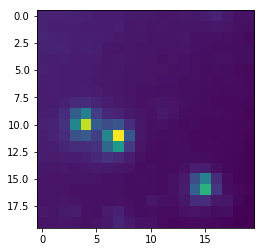

In [63]:
full_mask_med = []
full_mask_max = []

for cadence in range(len(pixels['FLUX'])):
    temp_mask = []
    rand_img = np.stack(pixels['FLUX'][cadence])
    
    center_pix = rand_img[ref_pix_y][ref_pix_x]
    right_pix = rand_img[ref_pix_y - 1][ref_pix_x]
    upper_pix = rand_img[ref_pix_y][ref_pix_x - 1]
    left_pix = rand_img[ref_pix_y - 1][ref_pix_x - 1]
    
    temp_mask.append(center_pix)
    temp_mask.append(right_pix)
    temp_mask.append(upper_pix)
    temp_mask.append(left_pix)
    full_mask_max.append(np.max(temp_mask))
    full_mask_med.append(np.median(temp_mask))

print(np.median(full_mask_max))
print(bkgnd_median + (3 * bkgnd_std))

if np.median(full_mask_max) > bkgnd_median + (3 * bkgnd_std):
    print("Fail")
else:
    print("Pass")
plt.imshow(rand_img)

## 6. Using visualization to look for a GRB-like event
    The following code creates a visualization of the Tess cutout. We observe this movie looking for a flash near our reference pixel.
    
    @author Lindsey Carboneau

In [64]:

'''
# step 1: read in the data
def getFITSdata(tessfile):
    fitsfile = fits.open(tessfile)
    headerdata = fitsfile[0].header
    checkdata = fitsfile[1].data
    fitsfile.close()
    pixeldata = np.asarray(checkdata)
    return (headerdata, pixeldata, checkdata)

header, pixels, check = getFITSdata(inputfile)
'''

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
fig.suptitle('{0}, {1},{2} GRB'.format(sec_data, rand_ra_str, rand_dec_str), fontsize=20)

ax_im = ax[0]
#ax_diff = ax[1]

Z = np.stack(pixels['FLUX'][0])
im_im = ax_im.imshow(Z, norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),
                   cmap='viridis', animated=True)
#im_diff = ax_diff.imshow(Z, norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),
                   #cmap='viridis', animated=True)

ax_im.set_title('Raw Flux from FFI - LogNorm')
#ax_diff.set_title('Diff Flux: Changes - LogNorm')
ax_im.set_yticklabels([])
ax_im.set_xticklabels([])
#ax_diff.set_yticklabels([])
#ax_diff.set_xticklabels([])

def updatefig(idx):
    image0 = np.stack(pixels['FLUX'][idx])
    try:
        imageN = np.stack(pixels['FLUX'][idx + 1])
    except IndexError:
        imageN = np.stack(pixels['FLUX'][idx])
    except Exception as ex:
        print('There was a different problem: ' + str(ex))
        
    im_im.set_array(image0)
    
    #im_diff.set_array(np.subtract(imageN, image0))
    
    return im_im, 

ani = animation.FuncAnimation(fig, updatefig, frames=len(pixels), blit=True, repeat=True, interval=400)
plt.close(fig)
HTML(ani.to_html5_video())

In [54]:
ani.save('{0},{1}_visual.mp4'.format(rand_ra_str,rand_dec_str))
shutil.move('./{0},{1}_visual.mp4'.format(rand_ra_str,rand_dec_str), './GRB-Movies_{2}_{3}/{0},{1}_visual.mp4'.format(rand_ra_str,rand_dec_str, RA, Dec))

'./GRB-Movies_56.795_-29.332/56.746103,-28.721251_visual.mp4'

In [55]:
test_count = 1
with open("results_56.795_-29.332.txt", 'r') as result:
    for line in result:
        test_count += 1
print(test_count)

38


In [56]:
flash_result = 'No Flash'
results = open("results_56.795_-29.332.txt", 'a')
results.write("({0}) {1}, {2} - {3}\n".format(test_count,rand_ra_str, rand_dec_str, flash_result))
results.close()